# Resampled Stats Example

See my [gist with functions here](https://gist.github.com/spestana/93682fecb659a8013e6c853b2630c15e).

---

Import required packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import xarray as xr

# for plotting
import matplotlib.pyplot as plt

Define the functions

In [2]:
def compute_modes(resampled, n=0):
    
    '''Given a resampled xarray object (xarray.core.resample.DataArrayResample),
       compute the modes ( rounding values with np.round(_,n) ), 
       return a pandas dataframe with the modes, counts, and groups (datetime)'''
    
    # Compute modes
    resampled_ModeResults = [stats.mode(np.round(x[1],n)) for x in resampled]
    
    # Get all the modes
    resampled_modes = [x.mode for x in resampled_ModeResults]
    # Reshape result into 1D array
    resampled_modes = np.array(resampled_modes).reshape(len(resampled))
    
    # Get the count for each mode
    resampled_counts = [x.count for x in resampled_ModeResults]
    # Reshape result into 1D array
    resampled_counts = np.array(resampled_counts).reshape(len(resampled))
    
    # Get the group (datetime) for each mode
    resampled_groups = np.array( list(resampled.groups.keys()) )
    
    # Create pandas dataframe
    d = {'modes': resampled_modes, 'counts': resampled_counts}
    df = pd.DataFrame(data=d, index=resampled_groups)
    
    return df

def resampled_stats(resampled, n=0, q=(.25,.75)):
    
    '''Given a resampled xarray object (xarray.core.resample.DataArrayResample),
    return a pandas dataframe with the mean, median, modes, counts, and groups (datetime)'''
    
    # Compute modes
    resampled_modes = compute_modes(resampled, n)
    
    # Compute and add mean, medians, modes, counts to a dataframe
    d = {'means': resampled.mean().values, 
         'medians': resampled.median().values, 
         'modes': resampled_modes.modes.values,
         'counts': resampled_modes.counts.values,
         'maxs': resampled.max().values,
         'mins': resampled.min().values,
         'ranges': resampled.max().values - resampled.min().values,
         'stds': resampled.std().values,
         'qUpper': resampled.quantile(q[1]).values,
         'qLower': resampled.quantile(q[0]).values,}
    
    df = pd.DataFrame(data=d, index=resampled_modes.index)
    
    return df

Open a data file

In [3]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
# squeeze out extra dimension after xarray dataset conversion
cues_ds = cues_ds.to_xarray().squeeze()
# compute difference value between GOES Tb and CUES Tss
cues_ds['goes_cues_diff'] = cues_ds.goes_tb_c - cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

---
## Monthly groupby example

Use groupby datetime.month to get "DataArrayResample" object for months 1-12

In [4]:
resampled_month = cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).groupby("datetime.month")

Use this DataArrayResample object in the functions defined above to compute the stats we want

In [5]:
resampled_month_df = resampled_stats(resampled_month, 0)

Preview the resulting pandas dataframe

In [6]:
resampled_month_df.head()

,means,medians,modes,counts,maxs,mins,ranges,stds,qUpper,qLower
1,-2.722015,2.364767,4.0,1442,15.981127,-55.774201,71.755328,13.270174,5.910251,-7.551765
2,3.149673,4.853243,4.0,1551,15.807728,-52.936379,68.744107,8.622994,8.019374,1.754047
3,-0.490177,2.397673,2.0,1460,16.838511,-63.529734,80.368245,10.686069,5.627662,-1.835164
4,-0.301482,2.595912,3.0,2439,14.881764,-56.601961,71.483725,9.287855,4.785089,-1.064166
5,0.091498,2.664780,2.0,2017,32.726410,-57.685058,90.411467,9.622706,4.886808,-0.229969


Plot some of the results (excluding "count" from the plot so we can see these other values)

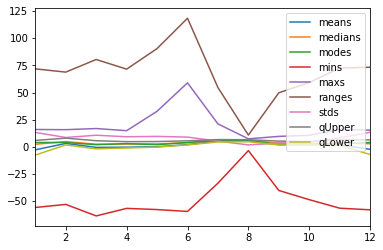

In [7]:
resampled_month_df.means.plot()
resampled_month_df.medians.plot()
resampled_month_df.modes.plot()
resampled_month_df.mins.plot()
resampled_month_df.maxs.plot()
resampled_month_df.ranges.plot()
resampled_month_df.stds.plot()
resampled_month_df.qUpper.plot()
resampled_month_df.qLower.plot()

plt.legend()

---
## Monthly resample example

Use groupby datetime.month to get "DataArrayResample" object for each month, year

In [8]:
resampled_month = cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).resample(datetime='1M')

Use this DataArrayResample object in the functions defined above to compute the stats we want

In [9]:
resampled_month_df = resampled_stats(resampled_month, 0)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/spestana/opt/anaconda3/envs/goes-li

Preview the resulting pandas dataframe

In [10]:
resampled_month_df.head()

,means,medians,modes,counts,maxs,mins,ranges,stds,qUpper,qLower
2017-03-31,-0.675956,1.908380,2.0,669,16.838511,-55.338199,72.176710,10.740207,5.286407,-1.660107
2017-04-30,-0.003838,2.686340,3.0,582,14.881764,-45.286603,60.168367,9.256338,5.334562,-1.795155
2017-05-31,1.303331,3.309119,3.0,683,32.726410,-45.730167,78.456577,9.244151,5.486477,0.908381
2017-06-30,4.151970,4.623129,6.0,692,58.898572,-59.413712,118.312283,8.191874,6.222851,2.698369
2017-07-31,7.376505,6.517395,6.0,309,21.100500,-14.259253,35.359753,3.455523,7.273163,5.964264


Plot some of the results (excluding "count" from the plot so we can see these other values)

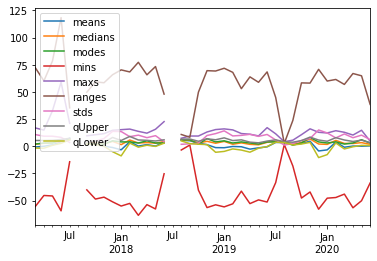

In [11]:
resampled_month_df.means.plot()
resampled_month_df.medians.plot()
resampled_month_df.modes.plot()
resampled_month_df.mins.plot()
resampled_month_df.maxs.plot()
resampled_month_df.ranges.plot()
resampled_month_df.stds.plot()
resampled_month_df.qUpper.plot()
resampled_month_df.qLower.plot()

plt.legend()

---

## 1-, 3, and 6-Hourly resample example

Use groupby datetime.month to get a "DataArrayResample" object for every 1, 3, and 6 Hours

In [12]:
resampled_1H = cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).resample(datetime='1H')
resampled_3H = cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).resample(datetime='3H')
resampled_6H = cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).resample(datetime='6H')

Use the DataArrayResample objects in the functions defined above to compute the stats we want

In [13]:
resampled_1H_df = resampled_stats(resampled_1H, 0)
resampled_3H_df = resampled_stats(resampled_3H, 0)
resampled_6H_df = resampled_stats(resampled_6H, 0)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/spestana/opt/anaconda3/envs/goes-li

Preview the resulting pandas dataframes

In [14]:
resampled_1H_df.head()

,means,medians,modes,counts,maxs,mins,ranges,stds,qUpper,qLower
2017-03-01 00:00:00,7.570866,7.494033,7.0,6,8.738867,6.555685,2.183182,0.745413,8.218768,6.920466
2017-03-01 01:00:00,7.341630,7.490804,8.0,6,8.208384,6.051536,2.156848,0.686093,7.918043,6.834057
2017-03-01 02:00:00,7.119483,7.082574,7.0,4,8.879285,5.399285,3.480000,0.930289,7.655037,6.404264
2017-03-01 03:00:00,8.675974,8.539158,9.0,7,9.652554,7.635391,2.017163,0.612623,9.184836,8.402066
2017-03-01 04:00:00,8.805983,8.981288,9.0,6,9.915391,7.462366,2.453025,0.730186,9.204938,8.415919


In [15]:
resampled_3H_df.head()

,means,medians,modes,counts,maxs,mins,ranges,stds,qUpper,qLower
2017-03-01 00:00:00,7.343993,7.315654,7.0,14,8.879285,5.399285,3.480000,0.815206,8.059937,6.765647
2017-03-01 03:00:00,8.717127,8.961288,9.0,17,9.992554,7.205792,2.786761,0.802619,9.257973,8.267338
2017-03-01 06:00:00,10.511737,10.244905,9.0,8,13.160090,7.911903,5.248187,1.466346,11.588872,9.302620
2017-03-01 09:00:00,8.557998,8.597551,8.0,7,11.274578,5.290776,5.983801,1.638528,9.944007,7.455070
2017-03-01 12:00:00,4.247245,4.208746,4.0,16,5.782938,2.865593,2.917345,0.770994,4.936646,3.702869


In [16]:
resampled_6H_df.head()

,means,medians,modes,counts,maxs,mins,ranges,stds,qUpper,qLower
2017-03-01 00:00:00,8.020890,8.094596,8.0,23,9.992554,5.399285,4.593269,1.061039,8.945238,7.248867
2017-03-01 06:00:00,9.549896,9.549730,9.0,14,13.160090,5.290776,7.869314,1.835050,10.890276,8.474596
2017-03-01 12:00:00,3.300497,2.857478,2.0,24,5.782938,1.847249,3.935690,1.111346,4.178408,2.322386
2017-03-01 18:00:00,7.272240,7.231741,7.0,23,10.360629,2.844623,7.516006,1.610366,8.374601,6.466852
2017-03-02 00:00:00,9.084299,8.428173,12.0,20,12.752539,5.345516,7.407023,2.460099,11.689583,6.896787


Plot some of the results as well as the underlying original data

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax

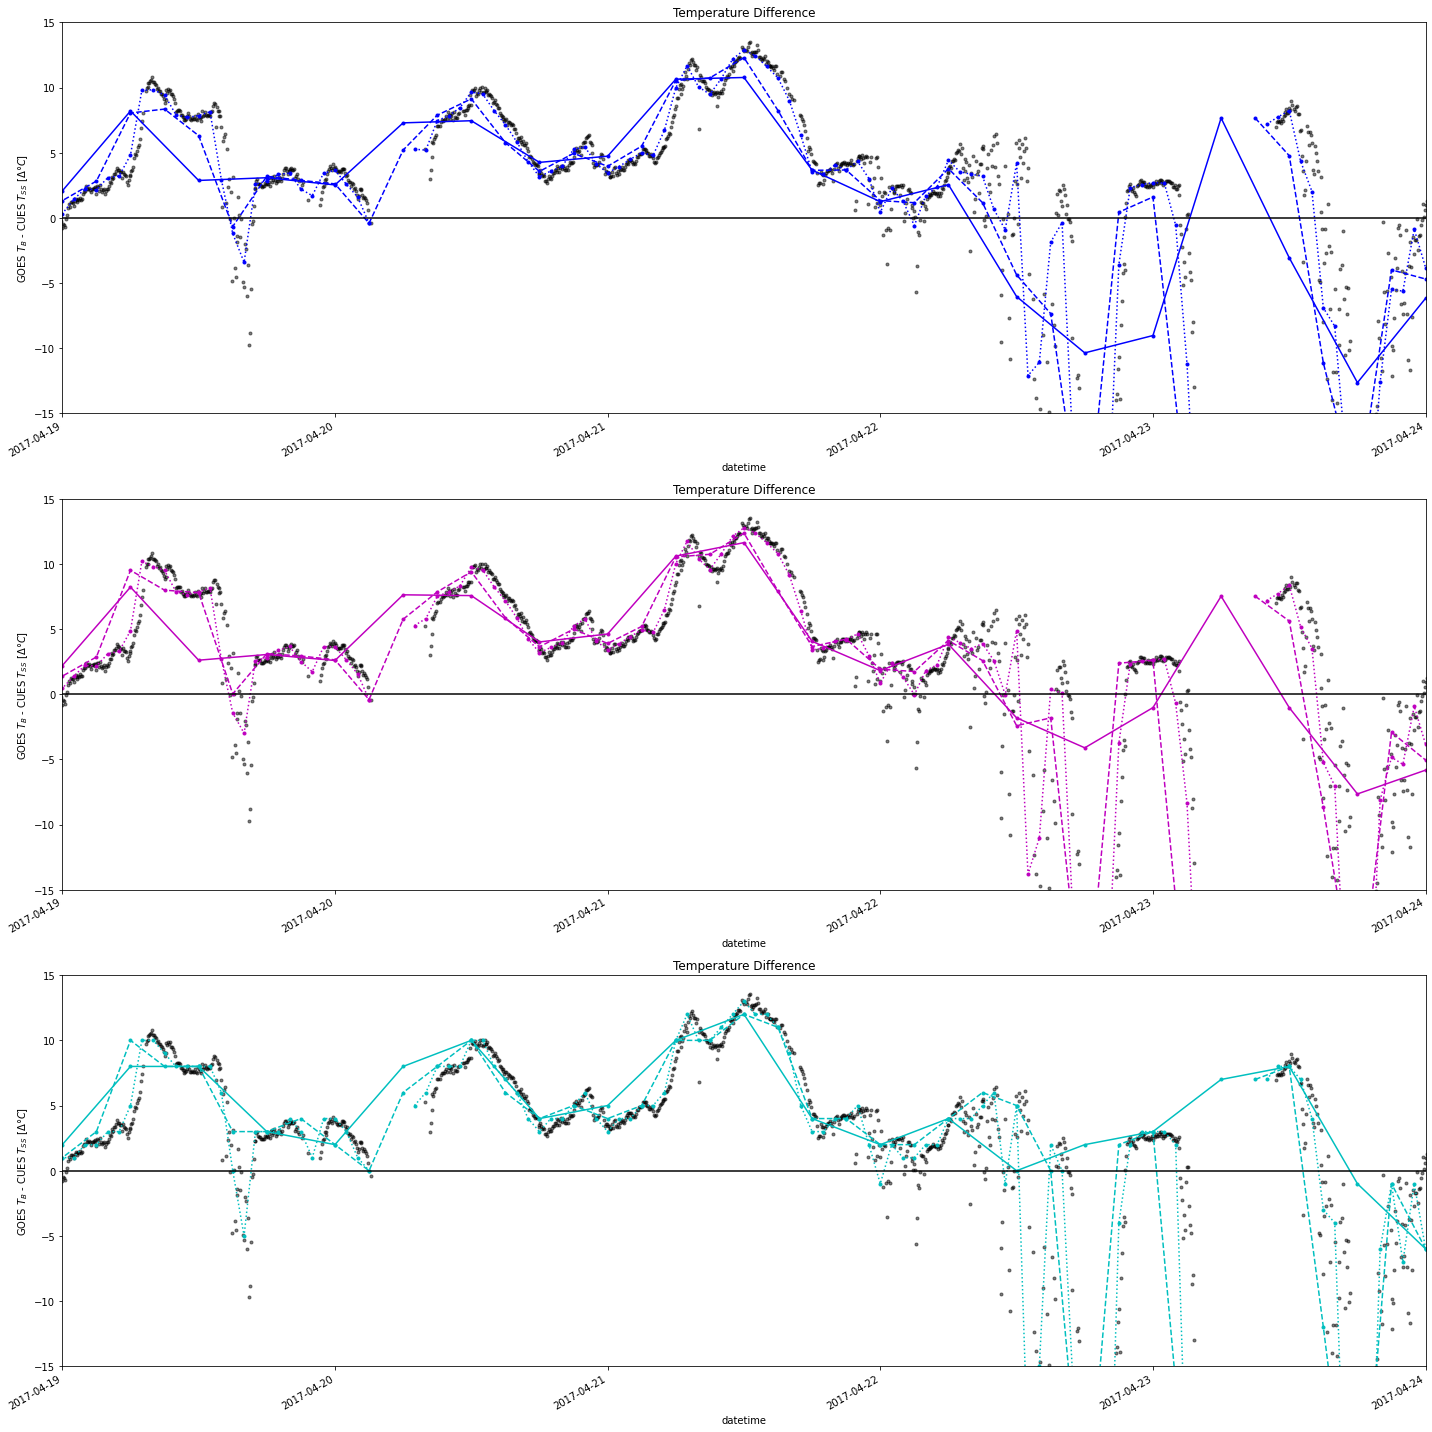

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20), tight_layout=True)


for this_ax in ax:
    cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).plot(ax=this_ax, 
                                                             color='k', 
                                                             linestyle='none', 
                                                             marker='.', 
                                                             alpha=0.5,
                                                             label='Difference')
# Means
resampled_1H_df.means.plot(ax=ax[0], color='b', linestyle=':', marker='.', label='1H Mean')
resampled_3H_df.means.plot(ax=ax[0], color='b', linestyle='--', marker='.', label='3H Mean')
resampled_6H_df.means.plot(ax=ax[0], color='b', linestyle='-', marker='.', label='6H Mean')


# Medians
resampled_1H_df.medians.plot(ax=ax[1], color='m', linestyle=':', marker='.', label='1H Median')
resampled_3H_df.medians.plot(ax=ax[1], color='m', linestyle='--', marker='.', label='3H Median')
resampled_6H_df.medians.plot(ax=ax[1], color='m', linestyle='-', marker='.', label='6H Median')


# Modes
resampled_1H_df.modes.plot(ax=ax[2], color='c', linestyle=':', marker='.', label='1H Mode')
resampled_3H_df.modes.plot(ax=ax[2], color='c', linestyle='--', marker='.', label='3H Mode')
resampled_6H_df.modes.plot(ax=ax[2], color='c', linestyle='-', marker='.', label='6H Mode')


for this_ax in ax:
    this_ax.axhline(0,color='k')
    this_ax.set_ylim((-15,15))
    this_ax.set_ylabel('GOES $T_{B}$ - CUES $T_{SS}$ [$\Delta\degree C$]')
    this_ax.set_title('Temperature Difference')
    this_ax.set_xlim((pd.Timestamp('2017-04-19'), pd.Timestamp('2017-04-24')))